In [1]:
import mapsims
import numpy as np
import healpy as hp
import pysm3.units as u
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt

# Running on the fly noise simulations with a custom hitmap

Inspired by [Aamir Ali's simulations for planet scans](https://gist.github.com/aamirmali/0bd0bfeab5fb00aa67d05c5e6838c12e)

By default `mapsims` loads predefined Simons Observatory hitmaps which were generated by time domain simulation, but we can override that by passing a custom hitmap.
The overall normalization of the hitmap has no influence.

In [2]:
nside = 256
npix = hp.nside2npix(nside)

## Generate a custom hitmap

In [3]:
hitmap = np.zeros(npix)
theta_pix, phi_pix = hp.pix2ang(nside, np.arange(npix))

In [4]:
patch_mask = (theta_pix > np.radians(20)) * (theta_pix < np.radians(50)) * (phi_pix > np.radians(20)) * (phi_pix < np.radians(60))

In [5]:
hitmap[patch_mask] = 1

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


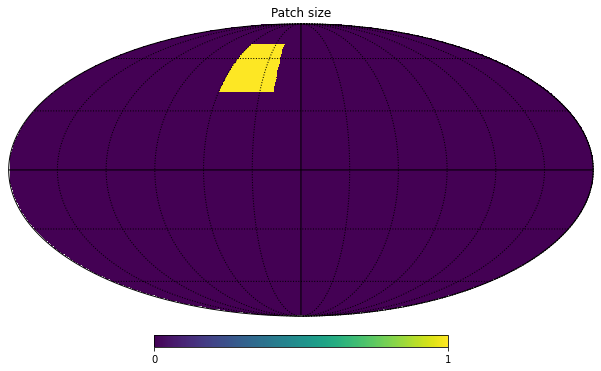

In [6]:
hp.mollview(hitmap, title="Patch size")
hp.graticule()

In [7]:
hitmap = hp.smoothing(hitmap, fwhm=np.radians(10))

Sigma is 254.796540 arcmin (0.074117 rad) 
-> fwhm is 600.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [8]:
hitmap[hitmap < 1e-2] = 0

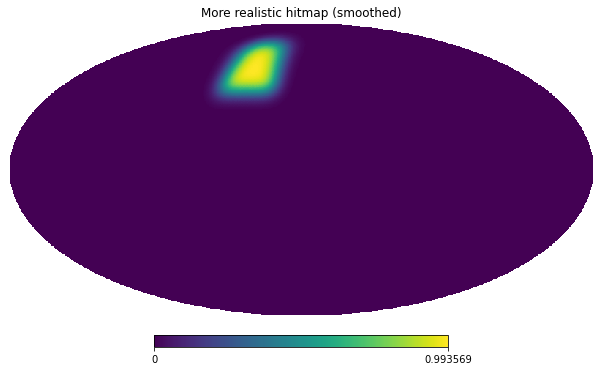

In [9]:
hp.mollview(hitmap, title="More realistic hitmap (smoothed)")

## Define integration time

By default, `mapsims.SONoiseSimulator` is going to set the integration time by the default mission length (5 years) and the default survey efficiency (0.2).
We can set the mission length to 1 year and then `survey_efficiency` to the integration time converted to years:

In [10]:
from astropy import units as u

In [11]:
integration_time = 10 * u.minute

In [12]:
integration_time_years = integration_time.to_value(u.year)

In [13]:
integration_time_years

1.901285268841737e-05

In [14]:
noise_sim = mapsims.SONoiseSimulator(nside=nside,
                                     LA_years=1,
                                     survey_efficiency=integration_time_years)

## Run the simulation

We only have 8 minutes of data, therefore the amount of noise is significant.
We can see by eye the modulation of the noise variance due to the hitmap.

In [15]:
tube = "LT1"

In [16]:
noise_maps = noise_sim.simulate(tube, hitmap=np.array((hitmap, hitmap)))

In [17]:
noise_maps.shape

(2, 1, 3, 786432)

In [18]:
channels = mapsims.parse_channels("tube:" + tube)[0]

In [19]:
channels

(Channel LT1_UHF1, Channel LT1_UHF2)

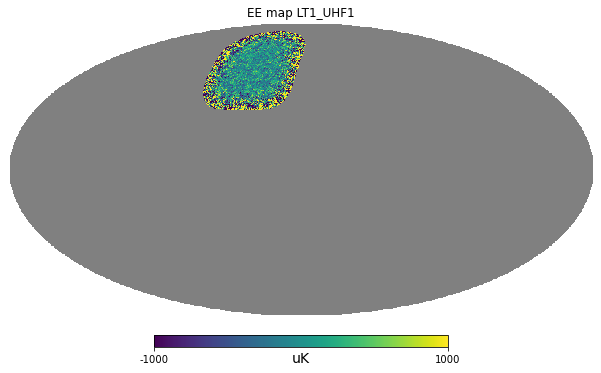

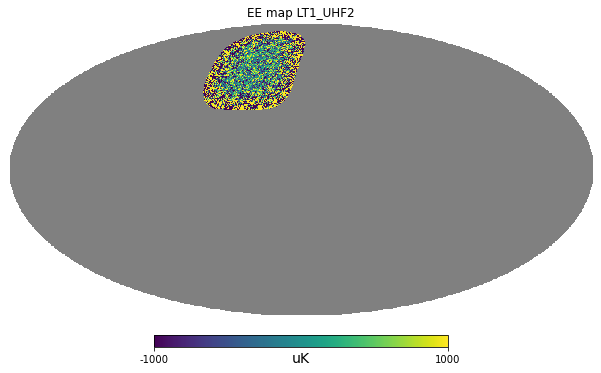

In [20]:
for ch, m in zip(channels, noise_maps):
    hp.mollview(m[0][1], title="EE map " + ch.tag, unit="uK", min=-1000, max=1000)